## Random Forest regression

Notes from [Random Forest in Python article](https://towardsdatascience.com/random-forest-in-python-24d0893d51c0) and data downloaded from the article's [GitHub repo](https://github.com/WillKoehrsen/Data-Analysis).

The following steps are typically carried out in many machine learning tasks:

1. State the question and determine required data
2. Acquire the data in an accessible format
3. Identify and correct missing data points/anomalies as required
4. Prepare the data for the machine learning model
5. Establish a baseline model that you aim to exceed
6. Train the model on the training data
7. Make predictions on the test data
8. Compare predictions to the known test set targets and calculate performance metrics
9. If performance is not satisfactory, adjust the model, acquire more data, or try a different modeling technique
10. Interpret model and report results visually and numerically

In [1]:
import pandas as pd

features_raw = pd.read_csv("../data/random_forest_explained/data/temps.csv")
features_raw.head(5)

,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41


In [2]:
print('The shape of our features is:', features_raw.shape)

The shape of our features is: (348, 9)


In [3]:
features_raw.describe()

,year,month,day,temp_2,temp_1,average,actual,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.511494,62.560345,59.760632,62.543103,60.034483
std,0.0,3.498380,8.772982,11.813019,11.767406,10.527306,11.794146,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,71.000000
max,2016.0,12.000000,31.000000,92.000000,92.000000,77.400000,92.000000,95.000000


One-hot encoding using `get_dummies()` and `iloc` to access rows and columns by index.

In [4]:
features = pd.get_dummies(features_raw)
features.iloc[:5, 8:]

,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0


Prepare features and labels.

In [5]:
import numpy as np
features = pd.get_dummies(features_raw)
labels = np.array(features['actual'])
# axis = 1 refers to the columns
features = features.drop('actual', axis = 1)
# saving feature names for later use
feature_list = list(features.columns)
features = np.array(features)
features.shape

(348, 14)

Split into training and testing sets.

In [6]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = \
  train_test_split(features, labels, test_size = 0.25, random_state = 42)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (261, 14)
Training Labels Shape: (261,)
Testing Features Shape: (87, 14)
Testing Labels Shape: (87,)


Our baseline will be the error we would get if we simply predicted the average max temperature for all days.

In [7]:
baseline_preds = test_features[:, feature_list.index('average')]
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  5.06


Use scikit-learn to import the random forest regression model, instantiate the model, and fit the model on the training data.

In [8]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [9]:
predictions = rf.predict(test_features)
errors = abs(predictions - test_labels)
print("Mean Absolute Error:", round(np.mean(errors), 2), "degrees.")

Mean Absolute Error: 3.83 degrees.


Mean average percentage error subtracted from 100%.

In [10]:
mape = 100 * (errors / test_labels)
accuracy = 100 - np.mean(mape)
print("Accuracy:", round(accuracy, 2), "%.")

Accuracy: 93.99 %.


The following cell is silenced (using Esc + r; to revert use Esc + y) but shows the code for extracting a single tree.

Feature importance.

In [11]:
importances = list(rf.feature_importances_)

feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
print(sorted(feature_importances, key = lambda x: x[1], reverse = True))

[('temp_1', 0.7), ('average', 0.19), ('day', 0.03), ('temp_2', 0.02), ('friend', 0.02), ('month', 0.01), ('year', 0.0), ('week_Fri', 0.0), ('week_Mon', 0.0), ('week_Sat', 0.0), ('week_Sun', 0.0), ('week_Thurs', 0.0), ('week_Tues', 0.0), ('week_Wed', 0.0)]


Text(0.5, 1.0, 'Variable importance')

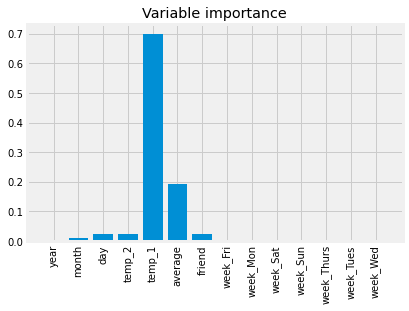

In [12]:
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = "vertical")
plt.xticks(x_values, feature_list, rotation = "vertical")
plt.title("Variable importance")

Random forest using only the two most important features.

In [13]:
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

important_indices = [feature_list.index('temp_1'), feature_list.index('average')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]
rf_most_important.fit(train_important, train_labels)
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 3.92 degrees.
Accuracy: 93.77 %.
